# Random Forests Exercise

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

import prepare

In [20]:
titanic = prepare.prep_titanic()

# creat baseline colum
titanic["baseline"] = [int(titanic.survived.mode()) for i in range(len(titanic))]

titanic.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,alone,sex_male,embarked_Q,embarked_S,baseline
0,0,0,3,male,22.0,1,0,7.2500,S,0,1,0,1,0
1,1,1,1,female,38.0,1,0,71.2833,C,0,0,0,0,0
2,2,1,3,female,26.0,0,0,7.9250,S,1,0,0,1,0
3,3,1,1,female,35.0,1,0,53.1000,S,0,0,0,1,0
4,4,0,3,male,35.0,0,0,8.0500,S,1,1,0,1,0


In [21]:
train, validate, test = prepare.split_data_(df=titanic, stratify_col="survived", random_state=95)
len(train), len(validate), len(test)

(534, 178, 179)

In [22]:
# separate features from target
xTrain = train.drop(columns=["passenger_id", 'survived', "age", 'sex', 'embarked', 'baseline'])
yTrain = train.survived

# validate
xVal = validate.drop(columns=["passenger_id", 'survived', "age", 'sex', 'embarked', 'baseline'])
yVal= validate.survived

1. Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.

In [23]:
# let start by running out baseline
baseline_acc_score = accuracy_score(train.survived, train.baseline)
baseline_acc_score

0.6161048689138576

In [24]:
# create random forest object
randFor = RandomForestClassifier(n_estimators=100, random_state=95)
randFor

RandomForestClassifier(random_state=95)

In [25]:
# fit model
randFor = randFor.fit(xTrain, yTrain)
randFor

RandomForestClassifier(random_state=95)

**feature importance**

In [26]:
# use the model to predict 
importance = randFor.feature_importances_
importance

array([0.09493788, 0.0603581 , 0.06677171, 0.38241401, 0.02724007,
       0.32360872, 0.01509969, 0.02956983])

In [27]:
# now make the prediction
yPred = randFor.predict(xTrain)
yTrain[:5]

84     1
138    0
369    1
577    1
212    0
Name: survived, dtype: int64

In [28]:
# probability of prediction
ypred_proba = randFor.predict_proba(xTrain)
ypred_proba[:5]

array([[0.20606061, 0.79393939],
       [0.99888889, 0.00111111],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ]])

In [29]:
# 1 == survived
# 0 == didn't make it
randFor.classes_

array([0, 1])

2. Evaluate your results using the model score, confusion matrix, and classification report.

In [30]:
# accuracy score
accuracy = randFor.score(xTrain, yTrain)
accuracy

0.9400749063670412

In [31]:
# confusion matrix
conMat = confusion_matrix(yTrain, yPred)
conMat

array([[318,  11],
       [ 21, 184]])

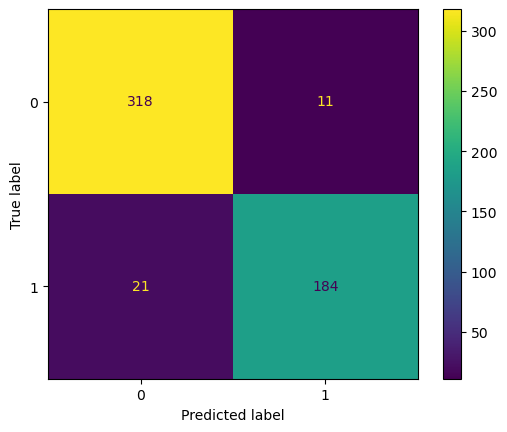

In [32]:
ConfusionMatrixDisplay.from_estimator(randFor, xTrain, yTrain)

3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [33]:
# classification report
report = classification_report(yTrain, yPred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       329
           1       0.94      0.90      0.92       205

    accuracy                           0.94       534
   macro avg       0.94      0.93      0.94       534
weighted avg       0.94      0.94      0.94       534



4. Run through steps increasing your min_samples_leaf and decreasing your max_depth.

In [41]:
result = []

for trees in range(2,20):
    # create ramdom tree object
    randFor = RandomForestClassifier(n_estimators= 100, min_samples_leaf= trees, max_depth = trees, random_state=95 )
    
    # fit the model
    randFor = randFor.fit(xTrain, yTrain)
    
    # get accuracy scores
    trainScore = randFor.score(xTrain, yTrain)
    validateScore = randFor.score(xVal, yVal)
    
    # create a dictionary of scores
    randFor_dict = {
        "estimators": trees,
        "train_score": trainScore,
        "validate_score": validateScore,
        "difference": trainScore - validateScore,
        "train_baseline_diff": baseline_acc_score - trainScore,
        "val_baseline_diff": baseline_acc_score - validateScore
    }
    
    result.append(randFor_dict)

In [42]:
randFor_df = pd.DataFrame(result)
randFor_df.head()

,estimators,train_score,validate_score,difference,train_baseline_diff,val_baseline_diff
0,2,0.788390,0.769663,0.018727,-0.172285,-0.153558
1,3,0.814607,0.797753,0.016854,-0.198502,-0.181648
2,4,0.831461,0.808989,0.022472,-0.215356,-0.192884
3,5,0.835206,0.792135,0.043071,-0.219101,-0.176030
4,6,0.846442,0.808989,0.037453,-0.230337,-0.192884


5. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

In [43]:
pd.DataFrame(randFor_df.max())

,0
estimators,19.000000
train_score,0.846442
validate_score,0.808989
difference,0.046816
train_baseline_diff,-0.172285
val_baseline_diff,-0.153558


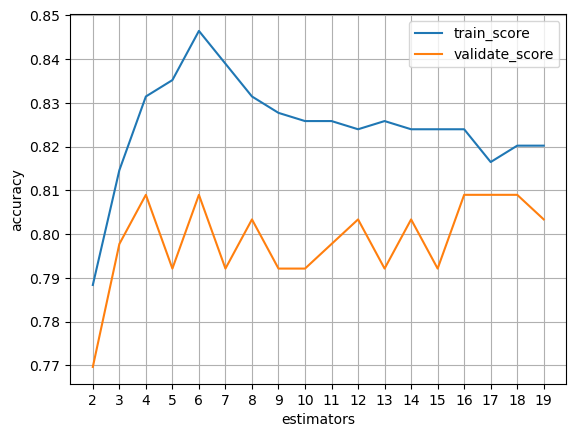

In [44]:
randFor_df[randFor_df.columns[:-3]].set_index("estimators").plot()
plt.ylabel('accuracy')
plt.xticks(np.arange(2,20))
plt.grid()
plt.show()

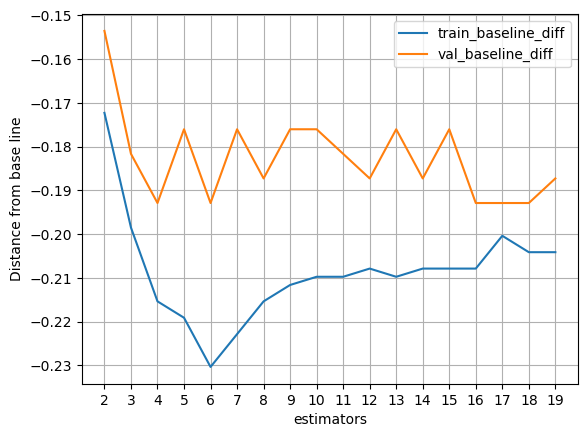

In [45]:
randFor_df.drop(columns=["difference","validate_score", "train_score"]).set_index("estimators").plot()
plt.ylabel('Distance from base line')
plt.xticks(np.arange(2,20))
plt.grid()
plt.show()

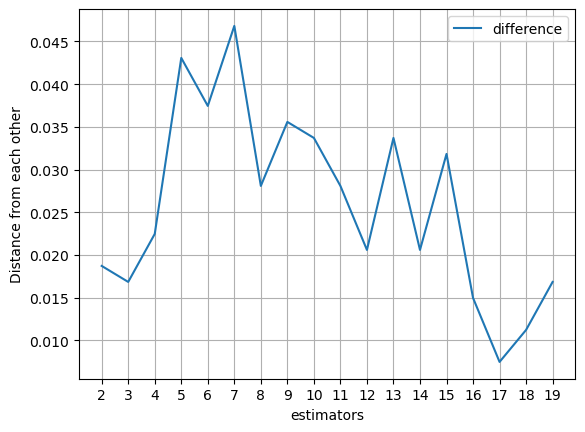

In [46]:
randFor_df[["difference", "estimators"]].set_index("estimators").plot()
plt.ylabel('Distance from each other')
plt.xticks(np.arange(2,20))
plt.grid()
plt.show()

**Model 17 performs better overall**